# Introduction
## **WELCOME!!👋👋**

This notebook is the final exercise in the Learning Path for the Maven Course: [Build Multi-Agent Applications - A Bootcamp](https://maven.com/aggregate-intellect/llm-systems). Before proceeding, ensure you have reviewed and understood the concepts covered in the previous two notebooks. These earlier lessons explored building:

- A Retrieval-Augmented Generation (RAG) Application using LangChain
- A Single-Agent Application using LangGraph.

By completing those, you'll be better prepared to tackle the challenges in this final notebook. Let’s put everything together and build a multi-agent application!


## Objective 🎯:

The goal is to create an multi-agent system that:
- Create a comprehensive proposal for pitching a new weight loss drug to a pharma company (e.g. Bausch Health)
- Incorporates a critique process, to provide feedback on the proposal
- Generate code to visualize financial projections based on the proposal

This builds on the example we looked at in the second exercise.

# Libraries Required for the Excercise

In [1]:
%%capture --no-stderr
!pip install -U --quiet langchain-community langchain_openai tavily-python langgraph

## Setup Required - APIs

In this notebook you'll be using OpenAI models for reasoning and generation, Tavily for searching facts online, langsmith for tracing and langgraph for agent orchestration.

In [2]:
import getpass
import os
from langsmith import utils

os.environ["LANGCHAIN_TRACING_V2"] = "true"
# define your langchain project name here
os.environ["LANGCHAIN_PROJECT"] = "maven-course-learning-path"

In [3]:
def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter your {key}:")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("TAVILY_API_KEY")

Enter your OPENAI_API_KEY:··········
Enter your LANGCHAIN_API_KEY:··········
Enter your TAVILY_API_KEY:··········


In [4]:
print('Is Tracing is enabled:', utils.tracing_is_enabled())

Is Tracing is enabled: True


## Imports

In [5]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from langchain_community.tools.tavily_search import TavilySearchResults

In [7]:
tavily_tool = TavilySearchResults(max_results=2)

## Define Nodes and Routing Logic

In [8]:
# Define the structured output for the Researcher node
class ResearcherResponse(BaseModel):
    """Respond to the user with this"""
    Net_Profit_year_1: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 1")
    Net_Profit_year_2: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 2")
    Net_Profit_year_3: float = Field(description="Forecasted net profit to bauch health after sales of wieght loss drug in year 3")
    Cost_of_Investment_year_1: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 1")
    Cost_of_Investment_year_2: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 2")
    Cost_of_Investment_year_3: float = Field(description="Forecasted cost of investment to bauch health for the wieght loss drug in year 3")


In [9]:
# Define the structured output for the Researcher node
class CritiqueResponse(BaseModel):
    """Respond to the user with this"""
    proposal_feedback: str = Field(description="Feedback of the critique agent on the sales proposal generated for the weight loss drug by the proposal agent")
    accept: bool = Field(description="Whether to accept the proposal or not")

In [10]:
# Define the state with a messages key and a step counter
class AgentState(MessagesState):
    step_count: int
    researcher_response: ResearcherResponse
    proposal: str
    proposal_accepted: bool
    graph_code: str

In [11]:
# Define the node that calls the model
def call_research_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage("You are a helpful AI assistant, please respond to the users query to the best of your ability!")
    model = ChatOpenAI(model="gpt-4o-mini")
    tools = [tavily_tool]
    model = model.bind_tools(tools)
    response = model.invoke([system_prompt] + state['messages'], config)
    # We return a list, because this will get added to the existing list
    current_count = state.setdefault('step_count', 0)
    return {"messages": [response], 'step_count': current_count + 1}

In [12]:
# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.with_structured_output(ResearcherResponse).invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    return {'proposal':state['messages'][-1].content,"researcher_response": response}

In [13]:
# Define the node that calls the model
def call_critique_model(
    state: AgentState,
    config: RunnableConfig,
):
    critique_prompt = """You are tasked with reviewing a sales proposal generated by a LLM. Review the proposal and provide
    clear feedback and actionable feedback on any spelling mistakes, don't comment on any other aspect.
    If it seems like the proposal is fine, then in proposal feedback mention that the proposal is good and accept the proposal.
    Otherwise provide concise proposal feedback and reject the proposal.
    """
    model = ChatOpenAI(model="gpt-4o-mini")
    messages = [
                   {"role": "user", "content": critique_prompt},
                    {"role": "assistant", "content": state['proposal']},
               ]
    response = model.with_structured_output(CritiqueResponse).invoke(messages)
    # We return a list, because this will get added to the existing list
    accepted = response.accept
    if accepted:
        return {
            "messages": [
                {"role": "user", "content": response.proposal_feedback},
                {"role": "assistant", "content": "okay, sending to this to coder agent"}],
            "proposal_accepted": True
        }
    else:
        return {
            "messages": [
                {"role": "user", "content": response.proposal_feedback},
            ],
            "proposal_accepted": False
        }

In [14]:
def route_critique(state: AgentState) -> Literal["research_agent", 'coder']:
    if state['proposal_accepted'] or state['step_count'] > 3:
        return 'coder'
    else:
        return "research_agent"

In [15]:
# Define the node that calls the model
def call_coder_model(
    state: AgentState,
    config: RunnableConfig,
):
    coder_prompt = """You are tasked with generating clear and executable Python code to create a graph based on sales proposal data produced by an LLM.
    The graph should represent the forecasted ROI (Return on Investment) for the next 3 years, using the provided data for Net_Profits and Cost_of_Investments for different years.
    Use the formula: ROI = (Net_Profits / Cost_of_Investments) * 100.
    Ensure the graph is well-labeled and visually clear:
    The X-axis should represent the years.
    The Y-axis should represent the ROI percentage.
    Add appropriate axis labels, a title, and a legend.
    Scale the axes appropriately to fit the data.
    Use a visually distinct line or bar plot to represent the ROI values over the years.
    The output should be Python code only, with no additional commentary or explanation.
    Ensure the code is executable without requiring additional modifications.
    """
    coder_agent_context = f"""
    Net_Profit_year_1: {state['researcher_response'].Net_Profit_year_1},
    Net_Profit_year_2: {state['researcher_response'].Net_Profit_year_2},
    Net_Profit_year_3: {state['researcher_response'].Net_Profit_year_3},
    Cost_of_Investment_year_1: {state['researcher_response'].Cost_of_Investment_year_1},
    Cost_of_Investment_year_2: {state['researcher_response'].Cost_of_Investment_year_2},
    Cost_of_Investment_year_3: {state['researcher_response'].Cost_of_Investment_year_3},
    """

    messages = [
                   {"role": "user", "content": coder_prompt},
                    {"role": "assistant", "content": coder_agent_context},
               ]
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages, config)

    return {"graph_code": response.content}

In [16]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

## Agent Workflow

In [17]:
search_tool_node = ToolNode([tavily_tool])

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("research_agent", call_research_model)
workflow.add_node("respond", respond)
workflow.add_node("search_tool", search_tool_node)
workflow.add_node('critique', call_critique_model)
workflow.add_node('coder', call_coder_model)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "research_agent")

# We now add a conditional edge
# We now add a conditional edge
workflow.add_conditional_edges(
    "research_agent",
    should_continue,
    {
        "continue": "search_tool",
        "respond": "respond",
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("search_tool", 'research_agent')
workflow.add_edge("respond", 'critique')
workflow.add_conditional_edges("critique", route_critique)
workflow.add_edge("coder", END)

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
# This is so that the memory is initialized with the graph
# This is useful if you want to persist state between runs
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=["coder"])

## Visualize Agent Workflow

In [18]:
def display_graph():
  from IPython.display import Image, display

  try:
      display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
  except Exception:
      # This requires some extra dependencies and is optional
      pass

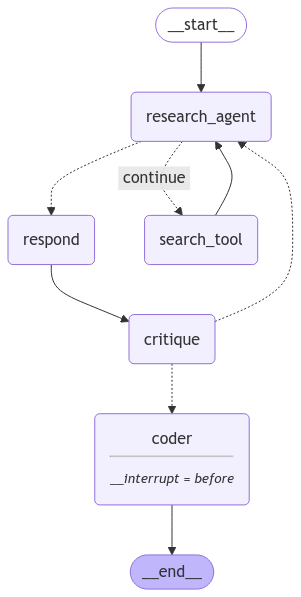

In [19]:
display_graph()

## Invoke Agent

In [20]:
def get_response(input_prompt, thread):


  return graph.invoke(
      {"messages": [HumanMessage(content=input_prompt)]},
      config=thread
  )

In [21]:
input_prompt = """You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Projections for Net_Profit for next 3 years
8. Projections for Cost_of_Investment for next 3 years

Ensure your proposal is well-structured, informative, and persuasive.
"""

In [22]:
# Run the graph
thread = {"configurable": {"thread_id": 101}}
state = get_response(input_prompt, thread)
state

{'messages': [HumanMessage(content='You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.\nUse the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.\n\nYour proposal should include:\n1. Executive Summary\n2. Company Overview (Bausch Health)\n3. Product Description\n4. Market Analysis\n5. Marketing Strategy\n6. Financial Projections\n   - Include estimated production costs\n   - Projected sales and revenue\n7. Projections for Net_Profit for next 3 years\n8. Projections for Cost_of_Investment for next 3 years\n\nEnsure your proposal is well-structured, informative, and persuasive.\n', additional_kwargs={}, response_metadata={}, id='a4644918-a0f8-4f8b-b23d-a2a4ae2510d8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MzIPbjHuwcAVXOm0DVoqQnM3', 'function': {'arguments': '{"query": "Bausch Health overview"}', 'name': 'tavily_search_results_json'}, 'type': 'function'},

## Inspect State

### Q. What is the Final proposal from the Agent

In [23]:
state['proposal']

'Thank you for your feedback! I appreciate your attention to detail and the opportunity to improve the proposal. Here’s a revised version that addresses the spelling errors and enhances the clarity of the financial projections:\n\n---\n\n# Proposal for a New Weight Loss Drug: Pitch to Bausch Health\n\n## 1. Executive Summary\nThe obesity epidemic is a pressing global health challenge, prompting a significant shift towards pharmaceutical solutions for weight management. This proposal outlines the development and marketing strategy for a new weight loss drug targeting the growing demand in the obesity drug market. Bausch Health, with its established presence in the specialty pharmaceutical sector, is uniquely positioned to leverage its expertise in drug development and marketing to capitalize on this opportunity. Our innovative drug aims to provide effective weight loss solutions, contributing to the company’s growth in a lucrative and expanding market.\n\n## 2. Company Overview (Bausch 

### Q. Was Proposal Accepted by the Crtique Model

In [24]:
state['proposal_accepted']

True

## If proposal look good go to next step for generating the code for building ROI graph using the coder Agent

In [25]:
graph_code = None
thread ={"configurable": {"thread_id": 101}}
for event in graph.stream(None, thread, stream_mode="values"):
    if 'graph_code' in event.keys():
        graph_code = event['graph_code']
        break

### Inspect the code generated by the Coder Agent

In [26]:
def check_formatting(code):
        # Check if the code contains markdown formatting with triple backticks
        if "```" in code:
            # Split the code by newlines
            lines = code.split('\n')
            # Filter out lines that start or end with triple backticks
            executable_lines = [line for line in lines if not line.strip().startswith('```')]
            # Join the remaining lines back into a single string
            return '\n'.join(executable_lines)
        else:
            # If no markdown formatting is detected, return the input as is
            return code
executable_code = check_formatting(graph_code)
print(executable_code)

import matplotlib.pyplot as plt

# Sales proposal data
years = [1, 2, 3]
net_profits = [-20000000.0, 10000000.0, 40000000.0]
cost_of_investments = [35000000.0, 15000000.0, 10000000.0]

# Calculate ROI
roi = [(net_profit / cost) * 100 for net_profit, cost in zip(net_profits, cost_of_investments)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, roi, marker='o', linestyle='-', color='b', label='ROI (%)')
plt.xticks(years, ['Year 1', 'Year 2', 'Year 3'])
plt.yticks(range(-100, 201, 50))

# Labels and Title
plt.xlabel('Years')
plt.ylabel('ROI (%)')
plt.title('Forecasted ROI Over the Next 3 Years')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Line at y=0 for reference
plt.grid()
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


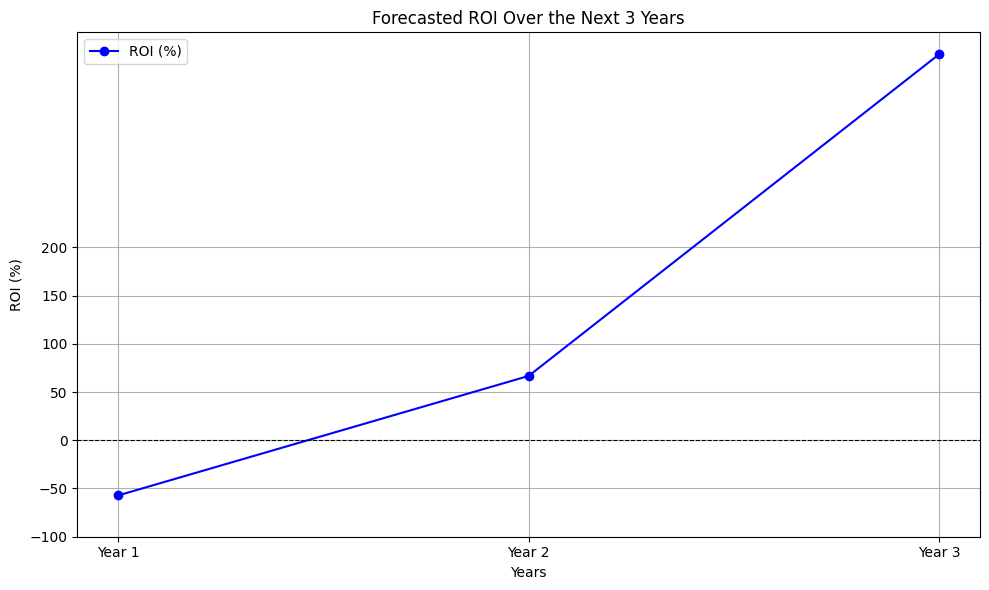

In [27]:
exec(executable_code)

## Human in the Loop

### We can change the state of the Agent at any time, for example the following changes year 3 net profit field of the researcher_response state,

In [28]:
state['researcher_response'].Net_Profit_year_3

40000000.0

In [29]:
state['researcher_response'].Net_Profit_year_3 += 777

In [30]:
state['researcher_response'].Net_Profit_year_3

40000777.0